In [1]:
import os
import sys
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import astropy
from astropy import stats
import geopy
from geopy import distance
import math
from itertools import combinations

import scipy
from scipy import signal
from scipy import fft

import cycler
from matplotlib import cm

import glob

In [6]:
def scatter_box(ax, x, y_data, xwidth=0.3, ywidth=0.1, color='black', edgecolor='none', flipxy=False, shading='95conf', alpha=0.3, markersize=5, linewidth=1, marker_linewidth=0, use='median', optimize_scatter_distance=False, optimize_scatter_distance_resolution=20, optimize_scatter_distance_y_scale=1, hide_markers=False, scatter_color=None, scatter_cmap='jet', scatter_norm_minmax=[0,1], random_scatter=True, rasterized=True):
    '''
    shading - can show quartiles, or 95% conf, or none
    optimize_scatter_distance - maximize distance between points, instead of randomizing. May take a long time.
    '''  
    if not hasattr(x,'__len__'):
        if use=='median':
            mean = np.median(y_data)
        elif use=='mean':
            mean = np.mean(y_data)
        y_data.sort()
        n = len(y_data)
        bottom_quartile = y_data[int(.25*n)]
        top_quartile = y_data[int(.75*n)]
        
        if random_scatter:
            if not optimize_scatter_distance:
                xvals = [x+np.random.random()*xwidth*2-xwidth for yi in range(len(y_data))]
            else:
                xvals = get_optimized_scatter_distance(y_data, xwidth, resolution=optimize_scatter_distance_resolution, y_scale_factor=optimize_scatter_distance_y_scale)
                xvals += x
        else:
            xvals = [x+0 for yi in range(len(y_data))]

        if shading == '95conf':
            import flystat.resampling
            conf_interval = flystat.resampling.bootstrap_confidence_intervals_from_data(y_data, use=use)
            
        
        if not flipxy:  
            if shading != 'none':
                ax.hlines([mean], x-xwidth, x+xwidth, colors=[color], linewidth=linewidth)
            if shading == 'quartiles':
                ax.fill_between([x-xwidth,x+xwidth], [bottom_quartile, bottom_quartile], [top_quartile, top_quartile], facecolor=color, edgecolor='none', alpha=alpha)
            elif shading == '95conf':
                ax.fill_between([x-xwidth,x+xwidth], [conf_interval[0], conf_interval[0]], [conf_interval[1], conf_interval[1]], facecolor=color, edgecolor='none', alpha=alpha)
            if not hide_markers:
                if scatter_color is not None: # len is a check to rgb tuples
                    ax.scatter(xvals, y_data, s=markersize, c=scatter_color, marker='o', cmap=scatter_cmap, linewidths=marker_linewidth, edgecolors=edgecolor, vmin=scatter_norm_minmax[0], vmax=scatter_norm_minmax[1], rasterized=rasterized)
                else:
                    ax.plot(xvals, y_data, 'o', markerfacecolor=color, markeredgecolor=edgecolor, markersize=markersize, rasterized=rasterized)
        else:
            if shading != 'none':
                ax.vlines([mean], x-xwidth, x+xwidth, colors=[color], linewidth=linewidth)
            if shading == 'quartiles':
                ax.fill_betweenx([x-xwidth,x+xwidth], [bottom_quartile, bottom_quartile], [top_quartile, top_quartile], facecolor=color, edgecolor='none', alpha=alpha)
            elif shading == '95conf':
                ax.fill_betweenx([x-xwidth,x+xwidth], [conf_interval[0], conf_interval[0]], [conf_interval[1], conf_interval[1]], facecolor=color, edgecolor='none', alpha=alpha)
            if not hide_markers:
                if hasattr(color, '__iter__') and len(color) > 3: # len is a check to rgb tuples
                    ax.scatter(y_data, xvals, s=markersize, c=scatter_color, marker='o', cmap=scatter_cmap, linewidths=marker_linewidth, edgecolors=edgecolor, vmin=scatter_norm_minmax[0], vmax=scatter_norm_minmax[1], rasterized=rasterized)
                else:
                    ax.plot(y_data, xvals, 'o', markerfacecolor=color, markeredgecolor=edgecolor, markersize=markersize, rasterized=rasterized)
            
    else:
        for i in range(len(x)):
            if use=='median':
                mean = np.median(y_data[i])
            elif use=='mean':
                mean = np.mean(y_data[i])
            y_data[i].sort()
            n = len(y_data[i])
            bottom_quartile = y_data[i][int(.25*n)]
            top_quartile = y_data[i][int(.75*n)]
            
            if not optimize_scatter_distance:
                xvals = [x[i]+np.random.random()*xwidth*2-xwidth for yi in range(len(y_data))]
            else:
                xvals = get_optimized_scatter_distance(y_data, xwidth, resolution=optimize_scatter_distance_resolution, y_scale_factor=optimize_scatter_distance_y_scale)
                xvals += x[i]
                

            if shading == '95conf':
                import flystat.resampling
                conf_interval = flystat.resampling.bootstrap_confidence_intervals_from_data(y_data[i], use=use)
            
            if not flipxy:
                if shading != 'none':
                    ax.hlines([mean], x[i]-xwidth, x[i]+xwidth, colors=[color], linewidth=linewidth)
                if shading == 'quartiles':
                    ax.fill_between([x[i]-xwidth,x[i]+xwidth], [bottom_quartile, bottom_quartile], [top_quartile, top_quartile], facecolor=color, edgecolor='none', alpha=alpha)
                elif shading == '95conf':
                    ax.fill_between([x-xwidth,x+xwidth], [conf_interval[0], conf_interval[0]], [conf_interval[1], conf_interval[1]], facecolor=color, edgecolor='none', alpha=alpha)
                if not hide_markers:
                    if hasattr(color, '__iter__') and len(color) > 3: # len is a check to rgb tuples
                        ax.scatter(xvals, y_data, s=markersize, c=scatter_color, marker='o', cmap=scatter_cmap, linewidths=marker_linewidth, edgecolors=edgecolor, vmin=scatter_norm_minmax[0], vmax=scatter_norm_minmax[1], rasterized=rasterized)
                    else:
                        ax.plot(xvals, y_data, 'o', markerfacecolor=color, markeredgecolor=edgecolor, markersize=markersize, rasterized=rasterized)
            else:
                if shading != 'none':
                    ax.vlines([mean], x[i]-xwidth, x[i]+xwidth, colors=[color], linewidth=linewidth)
                if shading == 'quartiles':
                    ax.fill_betweenx([x[i]-xwidth,x[i]+xwidth], [bottom_quartile, bottom_quartile], [top_quartile, top_quartile], facecolor=color, edgecolor='none', alpha=alpha)
                elif shading == '95conf':
                    ax.fill_betweenx([x-xwidth,x+xwidth], [conf_interval[0], conf_interval[0]], [conf_interval[1], conf_interval[1]], facecolor=color, edgecolor='none', alpha=alpha)
                if not hide_markers:
                    if hasattr(color, '__iter__') and len(color) > 3: # len is a check to rgb tuples
                        ax.scatter(y_data, xvals, s=markersize, c=scatter_color, marker='o', cmap=scatter_cmap, linewidths=marker_linewidth, edgecolors=edgecolor, vmin=scatter_norm_minmax[0], vmax=scatter_norm_minmax[1], rasterized=rasterized)
                    else:
                        ax.plot(y_data, xvals, 'o', markerfacecolor=color, markeredgecolor=edgecolor, markersize=markersize, rasterized=rasterized)
                

# Eventually will fix this so that notebook is more streamlined...
#path to directory containing hdf files
file_path = 'WindHDFFiles/Speed+Direction/'

#Get a list of all the .hdf files in the directory
WIND_files = glob.glob(file_path + '*.hdf')
N=len(WIND_files)

dfs=np.empty((N, 0)).tolist()

#only problem is this is sorted by alphabetical order instead of by date... will fix at some point 
for i in range (1,N):
    dfs[i]=pd.read_hdf(WIND_files[i])

# Reading all dfs separately... not efficient but makes manually checking mistakes easier

In [2]:
df1=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_10.20.20windgps_data.hdf')

In [3]:
df2=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_7.7.21windgps_data.hdf')

In [4]:
df3=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_9.26.21windgps_data.hdf')

In [5]:
df4=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_10.29.21windgps_data.hdf')

In [6]:
df5=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_10.30.21windgps_data.hdf')

In [7]:
df6=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_1.8.22windgps_data.hdf')

In [8]:
df7=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_1.11.22windgps_data.hdf')

In [9]:
df8=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_1.15.22windgps_data.hdf')

In [10]:
df9=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_4.30.22windgps_data.hdf')

In [11]:
df10=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_5.1.22windgps_data.hdf')

In [12]:
df11=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_5.2.22windgps_data.hdf')

In [13]:
df12=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_6.1.22windgps_data.hdf')

In [14]:
df13=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_6.3.22windgps_data.hdf')

In [15]:
df14=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_6.7.22windgps_data.hdf')

In [16]:
df15=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_6.8.22windgps_data.hdf')

In [17]:
df16=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_6.22.22windgps_data.hdf')

# Also not efficient, but separating dfs into just speed and direction. Useful for spectral analysis functions below

In [18]:
#if you just want S2
sdf1=df1[['S2_1', 'S2_2', 'S2_4', 'S2_5', 'S2_6', 'S2_7', 'S2_8', 'S2_9']]
sdf2=df2[['S2_1', 'S2_2', 'S2_3', 'S2_5', 'S2_6', 'S2_9']]
sdf3=df3[['S2_1', 'S2_2', 'S2_4', 'S2_5', 'S2_6', 'S2_7']]
sdf4=df4[['S2_1', 'S2_2', 'S2_3', 'S2_5', 'S2_6', 'S2_7']]
sdf5=df5[['S2_1', 'S2_2', 'S2_3','S2_5', 'S2_6', 'S2_7' ]]
sdf6=df6[['S2_1', 'S2_2', 'S2_3','S2_5', 'S2_6', 'S2_7' ]]
sdf7=df7[['S2_1', 'S2_2', 'S2_3', 'S2_4','S2_5', 'S2_6', 'S2_7' ]]
sdf8=df8[['S2_1', 'S2_2', 'S2_3', 'S2_4','S2_5', 'S2_6', 'S2_7' ]]
sdf9=df9[['S2_1', 'S2_2', 'S2_3','S2_5', 'S2_6', 'S2_8' ]]
sdf10=df10[['S2_1', 'S2_2', 'S2_3','S2_5', 'S2_6', 'S2_8' ]]
sdf11=df11[['S2_1', 'S2_2','S2_5', 'S2_6', 'S2_8' ]]
sdf12=df12[['S2_1', 'S2_2', 'S2_3','S2_5', 'S2_6', 'S2_7', 'S2_8' ]]
sdf13=df13[['S2_2', 'S2_3','S2_5', 'S2_6', 'S2_7', 'S2_8' ]]
sdf14=df14[['S2_2', 'S2_5', 'S2_6', 'S2_7', 'S2_8' ]]
sdf15=df15[['S2_2', 'S2_5', 'S2_6', 'S2_7', 'S2_8' ]]
sdf16=df16[['S2_2', 'S2_3', 'S2_5', 'S2_6', 'S2_7', 'S2_8' ]]

In [19]:
#if you just want D
ddf1=df1[['D_1', 'D_2', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'D_9']]
ddf2=df2[['D_1', 'D_2', 'D_3', 'D_5', 'D_6', 'D_9']]
ddf3=df3[['D_1', 'D_2', 'D_4', 'D_5', 'D_6', 'D_7']]
ddf4=df4[['D_1', 'D_2', 'D_3', 'D_5', 'D_6', 'D_7']]
ddf5=df5[['D_1', 'D_2', 'D_3','D_5', 'D_6', 'D_7' ]]
ddf6=df6[['D_1', 'D_2', 'D_3','D_5', 'D_6', 'D_7' ]]
ddf7=df7[['D_1', 'D_2', 'D_3', 'D_4','D_5', 'D_6', 'D_7' ]]
ddf8=df8[['D_1', 'D_2', 'D_3', 'D_4','D_5', 'D_6', 'D_7' ]]
ddf9=df9[['D_1', 'D_2', 'D_3','D_5', 'D_6', 'D_8' ]]
ddf10=df10[['D_1', 'D_2', 'D_3','D_5', 'D_6', 'D_8' ]]
ddf11=df11[['D_1', 'D_2','D_5', 'D_6', 'D_8' ]]
ddf12=df12[['D_1', 'D_2', 'D_3','D_5', 'D_6', 'D_7', 'D_8' ]]
ddf13=df13[['D_2', 'D_3','D_5', 'D_6', 'D_7', 'D_8' ]]
ddf14=df14[['D_2', 'D_5', 'D_6', 'D_7', 'D_8' ]]
ddf15=df15[['D_2', 'D_5', 'D_6', 'D_7', 'D_8' ]]
ddf16=df16[['D_2', 'D_3', 'D_5', 'D_6', 'D_7', 'D_8' ]]

# Functions

In [20]:
def get_fft(data,time):
    # Number of sample points
    N = len(time)
    # sample spacing
    time=np.array(time)
    T = 1.0 /(len(time)/(time[-1]-time[0]))
    # print(T)
    x = np.linspace(0.0, N*T, N)
    y = np.array(data)
    yf = scipy.fft.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
#     p=np.multiply(yf,time[-1])
    X=np.log10(xf[1:])
    Y=np.log10(2.0/N * np.abs(yf[1:(N//2)]))
#     P=np.log10(2.0/N * np.abs(p[1:(N//2)]))
    return(X,Y)

In [21]:
#split speed and difference dfs so that you can find averages on different time chunks
def split_df(df, chunk_size = 6000): #default chunks are 30 min
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks 

In [22]:
def spectrum1(h, dt=.1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [23]:
def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s

In [24]:
def spectrum3(h, dt=.1, nsmooth=5):
    """
    Detrend first.
    """
    t = np.arange(len(h))
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return spectrum2(h_detrended, dt=dt, nsmooth=nsmooth)
    

In [25]:
def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

def spectrum4(h, dt=.1, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    h_detrended = detrend(h)
    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    
    freqs, ps, psd = spectrum3(h_win, dt=dt, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [26]:
def avg_psd(array):
    chunks=split_df(array)
    N=len(chunks)-1
    freqs=np.empty((N, 0)).tolist()
    ps=np.empty((N, 0)).tolist()
    psd=np.empty((N, 0)).tolist()
    
    for i in range (0, N):
        freqs[i], ps[i], psd[i] =spectrum1(chunks[i], dt=.1)
    
    
    arrays = [np.array(x) for x in freqs]
    #freqs_avgdf=pd.DataFrame(arrays)
    #freqs_avg=freqs_avgdf.mean()
    freqs_avg= [np.mean(k,dtype=np.float64) for k in zip(*arrays)] 
    
    arrays2 = [np.array(x) for x in psd]
    #psd_avgdf=pd.DataFrame(arrays2)
    #psd_avg=psd_avgdf.mean()

    psd_avg= [np.mean(k,dtype=np.float64) for k in zip(*arrays2)] 

    return freqs_avg,psd_avg
    #return freqs, psd

def avgdf_psd (df):
    N=len(df.columns)
    all_df_freq=np.empty((N, 0)).tolist()
    all_df_psd=np.empty((N, 0)).tolist()
    
    for i in range (0,N):
        all_df_freq[i], all_df_psd[i] =avg_psd(df.iloc[:,i])

    arrays = [np.array(x) for x in  all_df_freq]
    
    freqs_avg= [np.mean(k,dtype=np.float64) for k in zip(*arrays)] 
    #freqs_avgdf=pd.DataFrame(arrays)
    #freqs_avg=freqs_avgdf.mean()
    arrays2 = [np.array(x) for x in all_df_psd]
    #psd_avgdf=pd.DataFrame(arrays2)
    #psd_avg=psd_avgdf.mean()
    psd_avg= [np.mean(k,dtype=np.float64) for k in zip(*arrays2)] 


    #return freqs_avg,psd_avg
    return freqs_avg, psd_avg

In [34]:
def unwrap_angle (directionarray, degrees=True):
    if (degrees==False):
        directionarray=+math.pi
    else:
        newdirection=directionarray*math.pi/180-math.pi
    return np.unwrap(newdirection)

def rewrap_angle(unwrappedarray, degrees=True):
    rewrapped = (unwrappedarray + np.pi) % (2 * np.pi)
    #same as np.arctan(np.cos(unwrappedarray), np.sin(unwrappedarray))
    if degrees:
        return rewrapped #this is in radians not degrees
    else:
        return rewrapped*180/math.pi

In [28]:
def unwrap_angulardf (directiondf, degrees=True):
    M=len(directiondf.columns)
    unwrappeddf=np.empty((M, 0)).tolist()
    for i in range (0,M):
        unwrappeddf[i]=unwrap_angle(directiondf.iloc[:,i])
    return pd.DataFrame(unwrappeddf, index=directiondf.columns).T    

# Analysis

In [80]:
freq_Dt=np.empty((16, 0)).tolist()
ps_Dt=np.empty((16, 0)).tolist()
psd_Dt=np.empty((16, 0)).tolist()
freq_D=np.empty((16, 0)).tolist()
psd_D=np.empty((16, 0)).tolist()

In [30]:
dfs_s2=[sdf1,sdf2,sdf3,sdf4,sdf5,sdf6,sdf7,sdf8,sdf9,sdf10,sdf11,sdf12,sdf13,sdf14,sdf15,sdf16]

In [31]:
dfs_d=[ddf1,ddf2,ddf3,ddf4,ddf5,ddf6,ddf7,ddf8,ddf9,ddf10,ddf11,ddf12,ddf13,ddf14,ddf15,ddf16]

In [82]:
N=len(freq_D)

for i in range (0,N):
    freq_D[i], psd_D[i]= avgdf_psd(unwrap_angulardf(dfs_d[i]))

In [42]:
desert=(0,6,7,11,12)
forest=(1,3,13,14,15)
urban=(2,4,5,8,9,10)

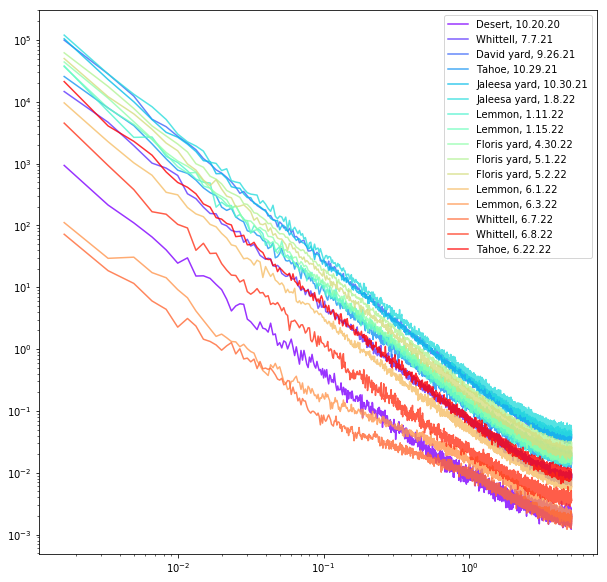

In [85]:
fig=plt.figure(figsize=(10,10))
N=len(freq_D)
color = iter(cm.rainbow(np.linspace(0, 1, N)))

for i in range (0,N):
    c = next(color)
    #freq_D[i], psd_D[i]= avgdf_psd(unwrap_angulardf(dfs_d[i]))
    plt.loglog(freq_D[i], psd_D[i], color=c, label=dates[i], alpha=.8)
    
plt.legend(bbox_to_anchor=(1,1))


In [150]:
t11,t2, t31=spectrum4(sdf2.S2_9)

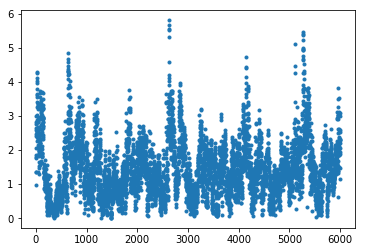

In [162]:
plt.plot(sdf9.S2_2[0:6000], '.')

(0, 100)

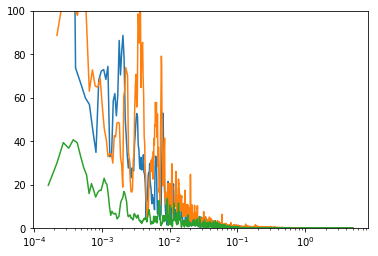

In [152]:
plt.semilogx(t1,t3)
plt.semilogx(t11,t31)
plt.semilogx(t17,t37)
plt.ylim(0,100)

(0, 600000)

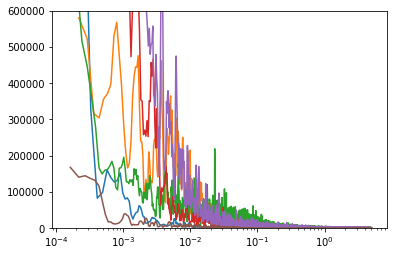

In [139]:
plt.semilogx(t1,t3)
plt.semilogx(t11,t31)
#plt.semilogx(t11u,t31u)
plt.semilogx(t12,t32)
#plt.semilogx(t13,t33)
#plt.semilogx(t14,t34)
plt.semilogx(t15,t35)
plt.semilogx(t16,t36)
plt.semilogx(t17,t37)
plt.ylim(0,600000)

In [35]:
for i in range (0,16):
    #for j in range (0,len(dfs_d[i].columns)):
    freq_Dt[i], ps_Dt[i], psd_Dt[i]= spectrum4(unwrap_angle(dfs_d[i].iloc[:,1]))

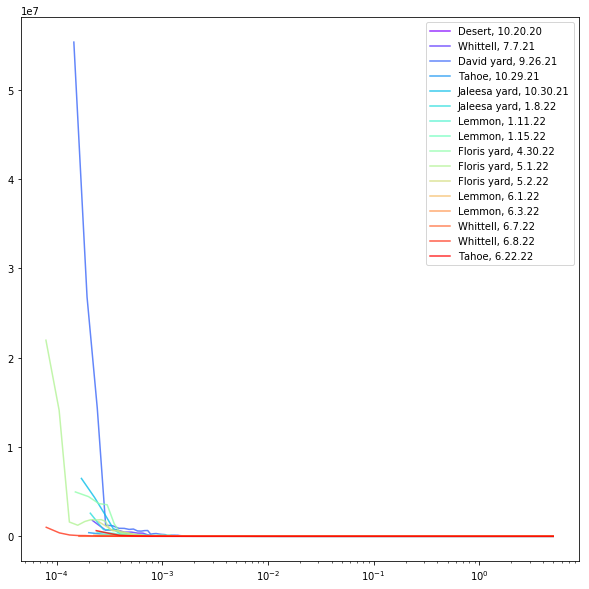

In [41]:
fig=plt.figure(figsize=(10,10))
N=len(freq_Dt)
color = iter(cm.rainbow(np.linspace(0, 1, N)))

for i in range(0,N):
    c = next(color)
    #freq_D[i], psd_D[i]= avgdf_psd(unwrap_angulardf(dfs_d[i]))
    plt.semilogx(freq_Dt[i], psd_Dt[i], color=c, label=dates[i], alpha=.8)
    
plt.legend(bbox_to_anchor=(1,1))    

In [ ]:
fig=plt.figure(figsize=(10,10))
N=len(forest)
color = iter(cm.rainbow(np.linspace(0, 1, N)))

for i in forest:
    c = next(color)
    #freq_D[i], psd_D[i]= avgdf_psd(unwrap_angulardf(dfs_d[i]))
    plt.semilogx(freq_D[i], psd_D[i], color=c, label=dates[i], alpha=.8)
    
plt.legend(bbox_to_anchor=(1,1))    

In [ ]:
fig=plt.figure(figsize=(10,10))
N=len(freq_D)
color = iter(cm.tab20(np.linspace(0, 1, N)))

for i in range (0,N):
    c = next(color)
    #freq_D[i], psd_D[i]= avgdf_psd(unwrap_angulardf(dfs_d[i]))
    plt.loglog(freq_D[i], psd_D[i], color=c, label=dates[i], alpha=.8)
    
plt.legend(bbox_to_anchor=(1,1)) 

In [ ]:
for i in range (0,16):
    freq[i], psd[i]= avgdf_psd(dfs_s2[i])
    #plt.loglog(freq[i], psd[i])
    #plt.loglog(freq1[i], psd1[i])

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freqs1)
n=N


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (0,n):
    c = next(color)
    #plt.loglog(freq_1[i], psd_1[i], color=c, alpha=.5, label=('unsmoothed', i))
    plt.loglog(freqs1[i], psds1[i], color=c, alpha=.8, label=('smoothed', dates[i]))

plt.loglog(np.array(.90)*freqs1[0], np.array(.90)*psds1[0], color='black', alpha=.8, label=('test'))    

plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min segment PSDs, 1.11.22, direction')

In [ ]:
plt.loglog(freqs1[0],psds1[0], color='blue', alpha=.8, label=('original'))    
plt.loglog(np.array(1)*freqs1[0], np.array(.20)*psds1[0], color='black', alpha=.8, label=('test'))    

In [ ]:
np.array(.1)

In [ ]:
f2,y2=scipy.signal.welch(df2.S2_2, fs=10)

In [ ]:
plt.loglog(f1,y1, color='blue', label='10.20.20')
plt.loglog(f2,y2, color='red', label='7.7.21')
#plt.loglog(f3,y3, color='purple', label='9.26.21')
#plt.loglog(f4,y4, color='red', label='10.29.21')
#plt.loglog(f5,y5, color='purple', label='10.30.21')
#plt.loglog(f6,y6, color='purple', label='1.8.22')
#plt.loglog(f7,y7,color='blue', label='1.11.22')
#plt.loglog(f8,y8,color='blue', label='1.15.22')
#plt.loglog(f9,y9,color='purple', label='4.30.22')
#plt.loglog(f10,y10,color='purple', label='5.1.22')           
#plt.loglog(f11,y11,color='purple', label='5.2.22')           
#plt.loglog(f12,y12,color='blue', label='6.1.22')
#plt.loglog(f13,y13,color='blue', label='6.3.22')           
#plt.loglog(f14,y14,color='red', label='6.7.22')           
#plt.loglog(f15,y15,color='red', label='6.8.22')           
#plt.loglog(f16,y16,color='red', label='6.22.22')
       
plt.legend(bbox_to_anchor=(1,1))

# Plotting

In [39]:
dates=['Desert, 10.20.20', 'Whittell, 7.7.21', 'David yard, 9.26.21', 'Tahoe, 10.29.21', 'Jaleesa yard, 10.30.21', 'Jaleesa yard, 1.8.22', 'Lemmon, 1.11.22', 'Lemmon, 1.15.22', 'Floris yard, 4.30.22', 'Floris yard, 5.1.22', 'Floris yard, 5.2.22', 'Lemmon, 6.1.22', 'Lemmon, 6.3.22', 'Whittell, 6.7.22', 'Whittell, 6.8.22', 'Tahoe, 6.22.22']

In [40]:
dfs=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16]

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq_4)
n=N


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (0,n):
    c = next(color)
    #plt.loglog(freq_1[i], psd_1[i], color=c, alpha=.5, label=('unsmoothed', i))
    plt.loglog(freq_4[i], psd_4[i], color=c, alpha=.8, label=('smoothed', i))

plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min segment PSDs, 1.11.22, direction')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq_4)
n=N


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (0,n):
    c = next(color)
    #plt.loglog(freq_1[i], psd_1[i], color=c, alpha=.5, label=('unsmoothed', i))
    plt.loglog(freq_4[i], psd_4[i], color=c, alpha=.8, label=('smoothed', i))

plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min segment PSDs, 10.20.20')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq_4)
n=N


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (0,n):
    c = next(color)
    #plt.loglog(freq_1[i], psd_1[i], color=c, alpha=.5, label=('unsmoothed', i))
    plt.loglog(freq_4[i], psd_4[i], color=c, alpha=.8, label=('smoothed', i))

plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min segment PSDs, 10.29.21')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq_4)
n=5


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (3,8):
    c = next(color)
    #plt.loglog(freq_1[i], psd_1[i], color=c, alpha=.5, label=('unsmoothed', i))
    plt.loglog(freq_4[i], psd_4[i], color=c, alpha=.9, label=('smoothed', i))

plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min segment PSDs, 10.30.21, beginning of day')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq4)
n=N


color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range (0,N):
    
    c = next(color)
    plt.loglog(freq1[i], psd1[i], color=c, alpha=.5, label=('unsmoothed', dates[i]))
    plt.loglog(freq4[i], psd4[i], color=c, alpha=1, label=('smoothed', dates[i]))
    
plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min avg PSDs for all dfs, smoothed v unsmoothed')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freq)
n=N


color = iter(cm.tab20b(np.linspace(0, 1, 16)))
for i in range (0,N):
    
    c = next(color)
    #plt.loglog(freq1[i], psd1[i], color=c, alpha=.5, label=('unsmoothed', dates[i]))
    plt.loglog(freq[i], psd[i], color=c, alpha=.8, label=(dates[i]))
    
plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min avg PSDs for all dfs, direction')

In [ ]:
fig=plt.figure(figsize=(10,10))

N=len(freqs1)
n=N


color = iter(cm.nipy_spectral(np.linspace(0, 1, 16)))
for i in range (0,N):
    
    c = next(color)
    #plt.loglog(freqs1[i], psds1[i], color=c, alpha=.5, label=('unsmoothed', dates[i]))
    plt.loglog(freq[i], psd[i], color=c, alpha=.8, label=(dates[i]))
    
plt.legend(bbox_to_anchor=(1,1))
plt.title('10 min avg PSDs for all dfs, direction')

In [ ]:
n = 22
color = plt.cm.terrain(np.linspace(0, 1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

In [ ]:
color=['darkred', 'firebrick', 'red', 'tomato', 'indianred', 'darkolivegreen', 'forestgreen', 'mediumseagreen', 'yellowgreen', 'lime', 'darkblue', 'royalblue', 'steelblue', 'paleturquoise', 'darkorchid', 'plum']

#color=['darkred', 'tomato','tomato','tomato','tomato', 'darkolivegreen', 'mediumseagreen','darkolivegreen','darkolivegreen', 'mediumseagreen', 'navy', 'blue', 'blue', 'paleturquoise', 'paleturquoise', 'paleturquoise']
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))



plt.loglog(freq[0], psd[0], color='blue', label='Desert, 10.20.20', alpha=.8)
plt.loglog(freq[6], psd[6], color='blue', label='Lemmon, 1.11.22', alpha=.8)
plt.loglog(freq[7],psd[7], color='blue',label='Lemmon, 1.15.22', alpha=.8)
plt.loglog(freq[11], np.array(.4)*psd[11], color='blue', label='Lemmon, 6.1.22', alpha=.8)
plt.loglog(freq[12], np.array(.2)*psd[12], color='blue', label='Lemmon, 6.3.22', alpha=.6)



plt.loglog(freq[1], np.array(.1)*psd[1], color='forestgreen', label='Whittell, 7.7.21', alpha=.6)
plt.loglog(freq[3], psd[3],color='forestgreen', label='Tahoe Forest, 10.29.21', alpha=.6)
plt.loglog(freq[13], psd[13],color='forestgreen', label='Whittell, 6.7.22', alpha=.6)
plt.loglog(freq[14], psd[14],color='forestgreen', label='Whittell, 6.8.22', alpha=.6)
plt.loglog(freq[15], np.array(.2)*psd[15],color='forestgreen', label='Tahoe Forest, 6.22.22', alpha=.6)


plt.loglog(freq[2],np.array(.3)*psd[2], color='purple', label='David Yard, 9.26.21', alpha=.6)
plt.loglog(freq[4], psd[4],color='purple', label='Jaleesa Yard, 10.30.21', alpha=.6)
plt.loglog(freq[5], psd[5],color='purple', label='Jaleesa Yard, 1.8.22', alpha=.6)
plt.loglog(freq[8], np.array(.2)*psd[8],color='purple', label='Floris Yard, 4.30.22', alpha=.6)
plt.loglog(freq[9], np.array(.3)*psd[9],color='purple', label='Floris Yard, 5.1.22', alpha=.6)
plt.loglog(freq[10], np.array(.1)*psd[10],color='purple', label='Floris Yard, 5.2.22', alpha=.6)

#plt.loglog(x, .05*x**m, color='k', linewidth=5, alpha=.7, label='-5/3')

plt.title('10 min PSD averages for backyards')

plt.legend(bbox_to_anchor=(1,1))

In [ ]:

plt.loglog(freq[2], psd[2], color='purple', label='David Yard, 9.26.21', alpha=.6)
plt.loglog(freq[4],psd[4],color='purple', label='Jaleesa Yard, 10.30.21', alpha=.6)
plt.loglog(freq[5], psd[5],color='purple', label='Jaleesa Yard, 1.8.22', alpha=.6)
plt.loglog(freq[8], psd[8],color='purple', label='Floris Yard, 4.30.22', alpha=.6)
plt.loglog(freq[9], psd[9],color='purple', label='Floris Yard, 5.1.22', alpha=.6)
plt.loglog(freq[10], psd[10],color='purple', label='Floris Yard, 5.2.22', alpha=.6)


plt.legend(bbox_to_anchor=(1,1))


In [ ]:
new=np.empty((16, 0)).tolist()

In [ ]:
for i in range (0,16):
    new[i]=np.mean(psd[i])
    plt.scatter([i],new[i], label=(dates[i]))
    
plt.legend(bbox_to_anchor=(1,1))    

In [ ]:
plt.plot(new, '.')

In [ ]:
fig=plt.figure(figsize=(10,6))
plt.loglog(freq[2], psd[2], label='9.26.21')
plt.loglog(freq[4], psd[4], label='10.30.21')
plt.loglog(freq[5], psd[5], label='1.8.22')
plt.loglog(freq[8], psd[8], label='4.30.22')
plt.loglog(freq[9], psd[9], label='5.1.22')
plt.loglog(freq[10], psd[10], label='5.2.22')

plt.loglog(freq1[2], psd1[2], label='9.26.21', alpha=.5)
plt.loglog(freq1[4], psd1[4], label='10.30.21', alpha=.5)
plt.loglog(freq1[5], psd1[5], label='1.8.22', alpha=.5)
plt.loglog(freq1[8], psd1[8], label='4.30.22', alpha=.5)
plt.loglog(freq1[9], psd1[9], label='5.1.22', alpha=.5)
plt.loglog(freq1[10], psd1[10], label='5.2.22', alpha=.5)

plt.legend(bbox_to_anchor=(1,1))

In [ ]:
fig=plt.figure(figsize=(10,10))

plt.loglog(freq[1], psd[1], label='7.7.21')
plt.loglog(freq[3], psd[3], label='10.29.21')
plt.loglog(freq[13], psd[13], label='6.7.22')
plt.loglog(freq[14], psd[14], label='6.8.22')
plt.loglog(freq[15], psd[15], label='6.22.22')

plt.legend(bbox_to_anchor=(1,1))

In [ ]:
#fig, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16] = plt.subplots(nrows=16, ncols=1, figsize=(15,35))

fig, [ax2, ax4,  ax14, ax15,  ax16, ] = plt.subplots(nrows=5, ncols=1, figsize=(15,30))


#ax1.scatter(df1.time, df1.D_2, s=1, color='k', label='Desert 10.20.20')
ax2.scatter(df2.time, df2.D_2, s=1, color='k', label='Forest 7.7.21')
#ax3.scatter(df3.time, df3.D_2, s=1, color='k', label='Backyard 9.26.21')
ax4.scatter(df4.time, df4.D_2, s=1, color='k', label='Forest 10.29.21')
#ax5.scatter(df5.time, df5.D_2, s=1, color='k', label='Backyard 10.30.21')
#ax6.scatter(df6.time, df6.D_2, s=1, color='k', label='Backyard 1.8.21')
#ax7.scatter(df7.time, df7.D_2, s=1, color='k', label='Lemmon 1.11.22')
#ax8.scatter(df8.time, df8.D_2, s=1, color='k', label='Lemmon 1.15.22')
#ax9.scatter(df9.time, df9.D_2, s=1, color='k', label='Backyard 4.30.22')
#ax10.scatter(df10.time, df10.D_2, s=1, color='k', label='Backyard 5.1.22')
#ax11.scatter(df11.time, df11.D_2, s=1, color='k', label='Backyard 5.2.22')
#ax12.scatter(df12.time, df12.D_2, s=1, color='k', label='Lemmon 6.1.22')
#ax13.scatter(df13.time, df13.D_5, s=1, color='k', label='Lemmon 6.3.22')
ax14.scatter(df14.time, df14.D_5, s=1, color='k', label='Forest 6.7.22')
ax15.scatter(df15.time, df15.D_5, s=1, color='k', label='Forest 6.8.22')
ax16.scatter(df16.time, df16.D_5, s=1, color='k', label='Forest 6.22.22')

#ax1.legend(bbox_to_anchor=(1,1))
ax2.legend(bbox_to_anchor=(1.16,1))
#ax3.legend(bbox_to_anchor=(1.16,1))
ax4.legend(bbox_to_anchor=(1.16,1))
#ax5.legend(bbox_to_anchor=(1.16,1))
#ax6.legend(bbox_to_anchor=(1.16,1))
#ax7.legend(bbox_to_anchor=(1.16,1))
#ax8.legend(bbox_to_anchor=(1.16,1))
#ax9.legend(bbox_to_anchor=(1.16,1))
#ax10.legend(bbox_to_anchor=(1.16,1))
#ax11.legend(bbox_to_anchor=(1.16,1))
#ax12.legend(bbox_to_anchor=(1,1))
#ax13.legend(bbox_to_anchor=(1,1))
ax14.legend(bbox_to_anchor=(1.16,1))
ax15.legend(bbox_to_anchor=(1.16,1))
ax16.legend(bbox_to_anchor=(1,1))